In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from pclib.nn.models import FCClassifier
from pclib.nn.layers import FCPW
from pclib.optim.train import train
from pclib.utils.plot import plot_stats
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y
from pclib.utils.customdataset import PreloadedDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:

class TanhTransform(object):
    def __init__(self, a=1., b=0., c=1.0):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, img):
        return ((img * self.a).tanh() + self.b) * self.c

class InvTanhTransform(object):
    def __call__(self, img):
        num = 1 + img
        div = (1 - img).clamp(min=1e-6)
        m = 0.5 * torch.log(num / div)
        return m

class SigmoidTransform(object):
    def __call__(self, img):
        return img.sigmoid()
    
class ReLUTanhTransform(object):
    def __call__(self, img):
        return F.relu(img.tanh())

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # InvTanhTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 1000
# dataset = torch.utils.data.Subset(dataset, range(length))

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

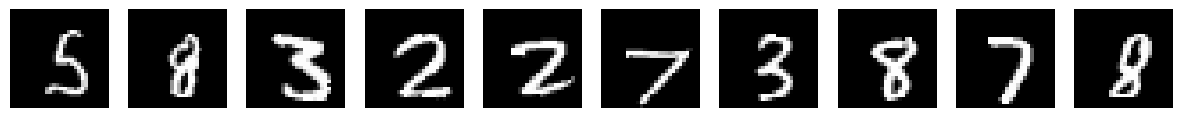

Max value:  tensor(2.8215, device='cuda:0')
Min value:  tensor(-0.4242, device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [6]:
seed = 42
torch.manual_seed(seed)

model = FCClassifier(
    input_size=INPUT_SHAPE, 
    num_classes=NUM_CLASSES, 
    hidden_sizes=[600, 600],
    bias=True, 
    symmetric=True, 
    precision_weighted=False,
    actv_fn=F.tanh,
    steps=60,
    gamma=0.1,
    ).to(device)
step = 0
stats = None

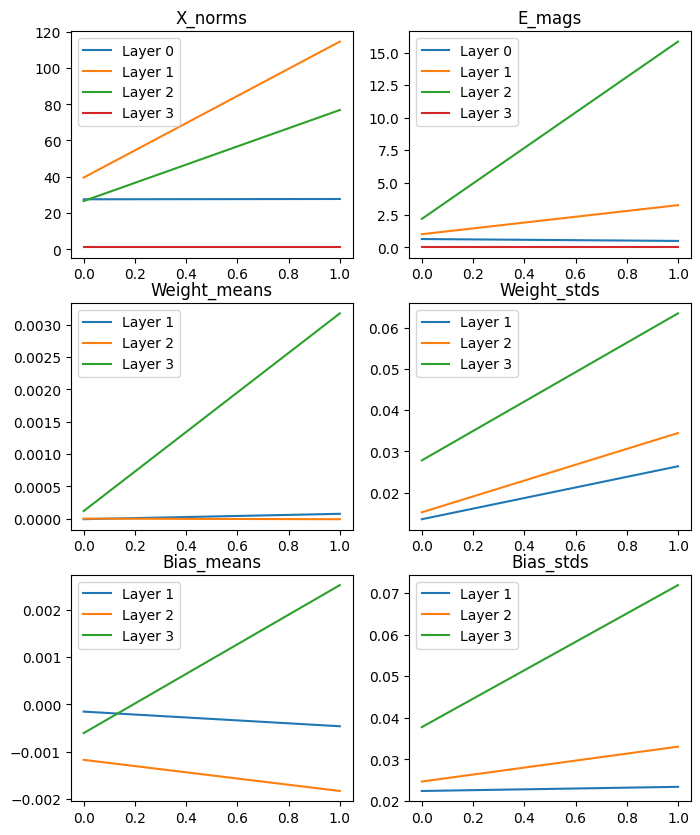

In [7]:
# Train Loop
LEARNING_RATE = 0.001
NUM_EPOCHS = 2
BATCH_SIZE = 1000
REG_COEFF = 0.2

step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    LEARNING_RATE, 
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    step=step, 
    stats=stats,
    optim='AdamW',
    grad_mode='manual',
    # assert_grads=True,
)
LEARNING_RATE = 0.0001
NUM_EPOCHS = 0
step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    LEARNING_RATE, 
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    step=step, 
    stats=stats,
    optim='AdamW',
)

plot_stats(stats, model)

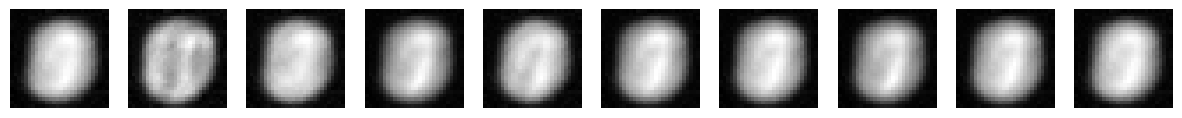

In [8]:
targets = torch.arange(NUM_CLASSES).to(device)
images = model.generate(targets)

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.detach().squeeze().cpu().view(28,28), cmap='gray')
    ax.axis('off')

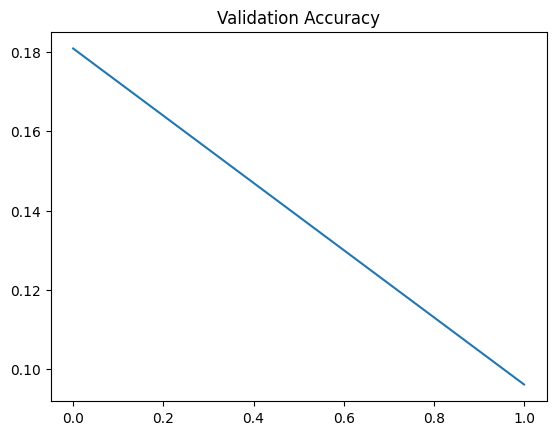

In [9]:
plt.plot(stats['val_acc'])
plt.title("Validation Accuracy")
plt.show()

In [10]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

Current Val Acc: 0.10041666666666667 | error_rate: 89.96 %


In [11]:
# # Shows statistics over multiple models. models = [model1, model2, ...]


# train_vfes = torch.tensor([stats[i]['train_vfe'][-1] for i in range(num_models)])
# val_vfes = torch.tensor([stats[i]['val_vfe'][-1] for i in range(num_models)])
# val_accs = torch.tensor([stats[i]['val_acc'][-1] for i in range(num_models)])

# # Show statistics across models, std is nan if num_models = 1
# print(f"Tra VFE - mean: {train_vfes.mean():.3f} | std: {train_vfes.std():.3f} | min: {train_vfes.min():.3f} | max: {train_vfes.max():.3f}")
# print(f"Val VFE - mean: {val_vfes.mean():.3f} | std: {val_vfes.std():.3f} | min: {val_vfes.min():.3f} | max: {val_vfes.max():.3f}")
# print(f"Val Acc - mean: {val_accs.mean():.3f} | std: {val_accs.std():.3f} | min: {val_accs.min():.3f} | max: {val_accs.max():.3f}")

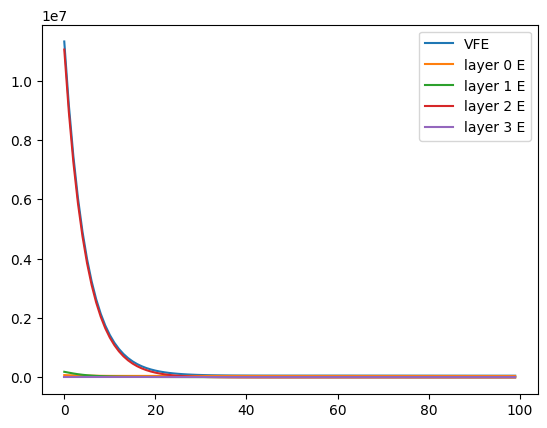

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


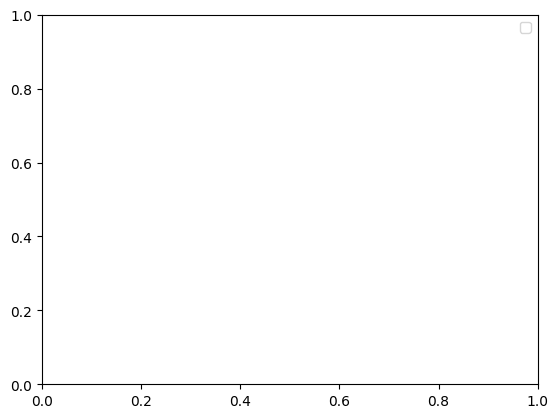

In [12]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images.view(images.shape[0], -1)
y = format_y(y, 10)
vfes, X, E = track_vfe(model, x, steps=100, plot_Es=True)

In [13]:
assert isinstance(model.layers[0], PrecisionWeighted), "This cell only works for PrecisionWeighted layers"
# show diag of weight_var matrix as 28x28 image for layer 0
model = model
layer = 0
weight_var = model.layers[0].weight_var.detach().cpu().numpy()
# weight_var = model.layers[-1].weight_var.diag().reshape(28,28).detach().cpu().numpy()
plt.imshow(weight_var, cmap='gray')
plt.colorbar()
plt.show()
weight_var.min(), weight_var.max()


NameError: name 'PrecisionWeighted' is not defined